<a href="https://colab.research.google.com/github/lorenzo1285/Econometria/blob/main/arima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importacion de Paqueterias

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pmdarima as pm
from pmdarima import model_selection
from darts import TimeSeries
from darts.models import AutoARIMA, ARIMA
from darts.utils.statistics import (plot_hist, 
                                    plot_residuals_analysis,
                                    check_seasonality)
from darts.metrics import (mape, mase, mae, mse, ope, r2_score, rmse, rmsle)
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
sns.set_style("whitegrid")
%matplotlib inline

# Carga de datos

In [ ]:
df = pd.read_excel('balaza comercial.xlsx')
df.head()

,Fecha,VAL_USD
0,2012-01-01,37597.547
1,2012-02-01,38595.389
2,2012-03-01,41356.070
3,2012-04-01,37700.602
4,2012-05-01,39545.208


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Fecha    129 non-null    datetime64[ns]
 1   VAL_USD  129 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.1 KB


# Preparacion de datos

In [ ]:
series = TimeSeries.from_dataframe(df, time_col='Fecha', value_cols='VAL_USD') # convert to TimeSeries object
series.head()

<TimeSeries (DataArray) (Fecha: 5, component: 1, sample: 1)>
array([[[37597.547]],

       [[38595.389]],

       [[41356.07 ]],

       [[37700.602]],

       [[39545.208]]])
Coordinates:
  * Fecha      (Fecha) datetime64[ns] 2012-01-01 2012-02-01 ... 2012-05-01
  * component  (component) object 'VAL_USD'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [ ]:
df.set_index('Fecha', inplace=True)
df.index = pd.to_datetime(df.index)
df.head()

,VAL_USD
Fecha,
2012-01-01,37597.547
2012-02-01,38595.389
2012-03-01,41356.070
2012-04-01,37700.602
2012-05-01,39545.208


# Visualizacion de datos

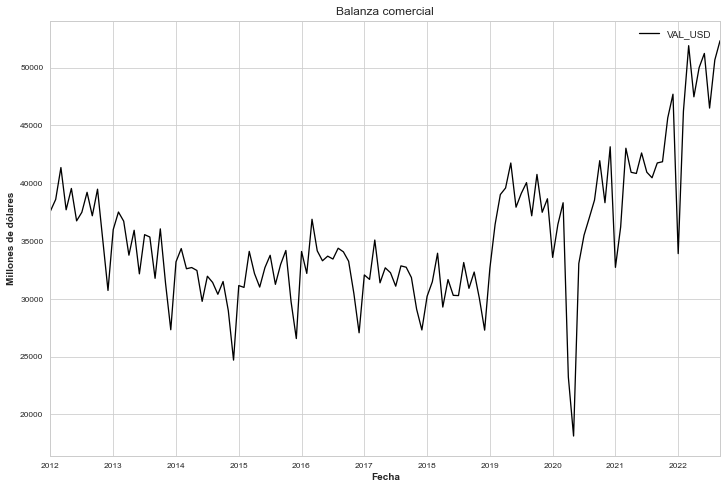

In [ ]:
df.plot(figsize=(12,8))
plt.title('Balanza comercial')
plt.ylabel('Millones de dólares')
plt.xlabel('Fecha')
plt.show()

# Determinacion de Estacionalidad

In [ ]:
def fuller_test(data):
    
    print(" > Is the data stationary ?")
    dftest = adfuller(data, autolag='AIC')
    print("Test statistic = {:.3f}".format(dftest[0]))
    print("P-value = {:.3f}".format(dftest[1]))
    print("Critical values :")
    for k, v in dftest[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

In [ ]:
fuller_test(df)

 > Is the data stationary ?
Test statistic = 0.454
P-value = 0.983
Critical values :
	1%: -3.4885349695076844 - The data is not stationary with 99% confidence
	5%: -2.887019521656941 - The data is not stationary with 95% confidence
	10%: -2.5803597920604915 - The data is not stationary with 90% confidence


# Autocorrelograma

In [ ]:
def autocorrelation_plot(data):
    fig, ax = plt.subplots(3, figsize=(12,6))
    ax[0] = plot_acf(data.dropna(), ax=ax[0], lags=24,)
    ax[1] = plot_pacf(data.dropna(), ax=ax[1], lags=24)
    ax[2] = data.plot(ax=ax[2])

c:\Users\LorenzoCardenas\anaconda3\envs\Dart\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


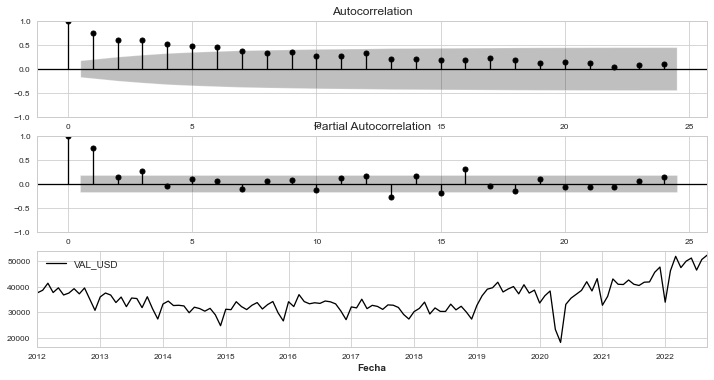

In [ ]:
autocorrelation_plot(df)

In [ ]:
is_seasonal, periodicity = check_seasonality(series, max_lag=240)
dict_seas ={
    "is seasonal?":is_seasonal, 
    "periodicity (months)":f'{periodicity:.1f}', 
    "periodicity (~years)": f'{periodicity/12:.1f}'}
_ = [print(k,":",v) for k,v in dict_seas.items()]

is seasonal? : True
periodicity (months) : 9.0
periodicity (~years) : 0.8


# Descomposicion de la serie

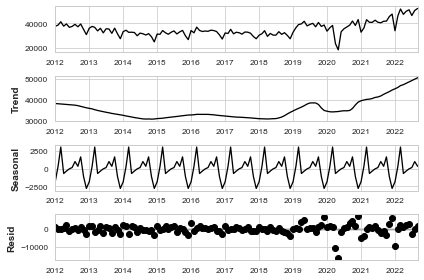

In [ ]:
ts_decomposed = seasonal_decompose(df ,model='additive',extrapolate_trend=True)
ts_trend = ts_decomposed.trend
ts_seasonal = ts_decomposed.seasonal
ts_residual = ts_decomposed.resid
ts_decomposed.plot()
plt.show()



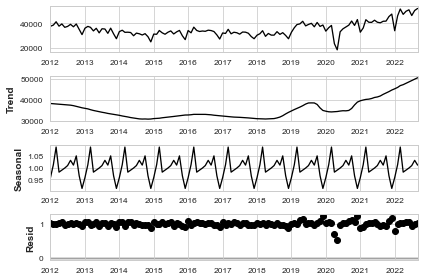

In [ ]:
ts_decomposed = seasonal_decompose(df ,model='multiplicative',extrapolate_trend=True)
ts_trend = ts_decomposed.trend
ts_seasonal = ts_decomposed.seasonal
ts_residual = ts_decomposed.resid
ts_decomposed.plot()
plt.show()

# Time Series Objet

In [ ]:
df.reset_index(inplace=True)
df.head()

,Fecha,VAL_USD
0,2012-01-01,37597.547
1,2012-02-01,38595.389
2,2012-03-01,41356.070
3,2012-04-01,37700.602
4,2012-05-01,39545.208


In [ ]:
is_seasonal, periodicity = check_seasonality(series, max_lag=240)
dict_seas ={
    "is seasonal?":is_seasonal, 
    "periodicity (months)":f'{periodicity:.1f}', 
    "periodicity (~years)": f'{periodicity/12:.1f}'}
_ = [print(k,":",v) for k,v in dict_seas.items()]

is seasonal? : True
periodicity (months) : 9.0
periodicity (~years) : 0.8


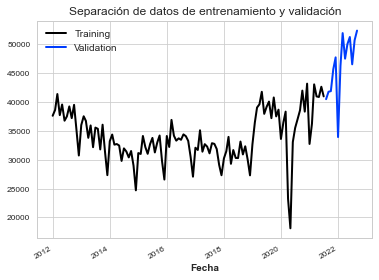

<Figure size 864x576 with 0 Axes>

In [ ]:
training, validation = series.split_before(.9) # split the data into training and validation sets
training.plot(label='Training') # plot the training set
validation.plot(label='Validation') # plot the validation set
plt.title("Separación de datos de entrenamiento y validación")
plt.figure(figsize=(12,8));

In [ ]:
def plot_fitted(pred, act, model): # function to plot the fitted values
    plt.figure(figsize=(12,5)) # set the figure size 
    act.plot(label='actual') # plot the actual values
    pred.plot(label='prediction',low_quantile=0.05, high_quantile=0.95) # plot the predicted values
    plt.title("Model: {0}".format(model) + ' | MAPE: {:.2f}%'.format(mape(pred, act))) # set the title
    plt.legend(); # show the legend

In [ ]:
def metrics(val, forecast, train): # function to calculate the metrics
    res_mape = mape(val, forecast).round(5) # MAPE
    res_mae = mae(val, forecast).round(5) # MAE
    res_r2 = r2_score(val, forecast).round(5) # R2
    #res_rmse = rmse(val, forecast).round(5) # RMSE
    res_rmsle = rmsle(val, forecast).round(5) # RMSLE
    res_mase = mase(val, forecast, insample=train).round(5) # MASE
    res_accuracy = {"MAPE": res_mape, "MAE": res_mae, "R squared": -
                    res_r2, "RMSLE": res_rmsle, "MASE": res_mase,}

    results = pd.DataFrame.from_dict(res_accuracy, orient='index', columns=['Value'])
    return results

# Modelo ARIMA

In [ ]:
arima = ARIMA(p=2,d=1,q=6, seasonal_order=(6,1,7,12)) # create an ARIMA model

In [ ]:
arima.fit(training) # fit the model to the training set

c:\Users\LorenzoCardenas\anaconda3\envs\Dart\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\LorenzoCardenas\anaconda3\envs\Dart\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
forecast_arima = arima.predict(n=len(validation)) # predict the validation set

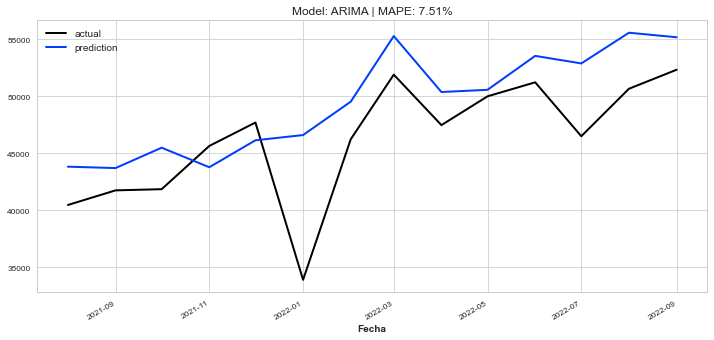

In [ ]:
plot_fitted(forecast_arima, validation, 'ARIMA') # plot the fitted values

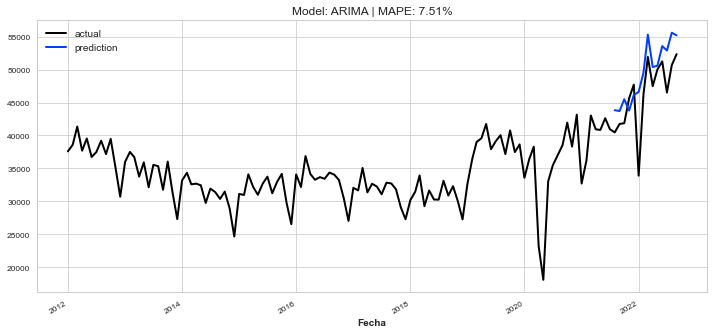

In [ ]:
plot_fitted(forecast_arima, series, 'ARIMA') # plot the fitted values

In [ ]:
metrics(validation, forecast_arima, training) # calculate the metrics

,Value
MAPE,8.62906
MAE,3693.43156
R squared,-0.14493
RMSLE,0.10748
MASE,1.34811


In [ ]:
arima_1 = arima.fit(series) # fit the model to the entire dataset


c:\Users\LorenzoCardenas\anaconda3\envs\Dart\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\LorenzoCardenas\anaconda3\envs\Dart\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
forecast_arima_1 = arima.predict(n=12) # predict the next 12 months


<Figure size 864x360 with 0 Axes>

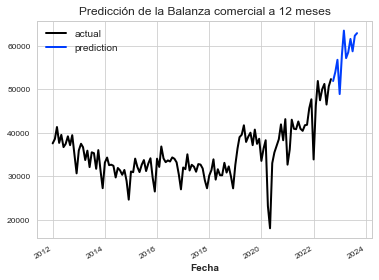

<Figure size 864x360 with 0 Axes>

In [ ]:
series.plot(label='actual') # plot the actual values
forecast_arima_1.plot(label='prediction') # plot the predicted values
plt.title("Predicción de la Balanza comercial a 12 meses") # set the title
plt.legend(); # show the legend
plt.figure(figsize=(12,5)) 

In [ ]:
forecast_arima_1.pd_dataframe()

component,VAL_USD
Fecha,
2022-10-01,51900.417369
2022-11-01,53980.398428
2022-12-01,56766.782770
2023-01-01,48905.642903
2023-02-01,57848.655861
2023-03-01,63466.525199
2023-04-01,57151.459142
2023-05-01,58491.687694
2023-06-01,61563.486755
